# Analisis de negocio para CallMeMaybe

## Descripsion del proyecto: 
El objetivo de este análisis es evaluar el comportamiento de los usuarios de la compañia de telefonia virtual CallMeMaybe ya que se esta desarrollando una nueva funcion que ayude a los supervisores y las supervisoras a determinar cuales son los operadores menos eficases

El análisis incluirá limpieza de datos, revisión de valores, y la aplicación de pruebas estadísticas para evaluar si los cambios propuestos aportaban un beneficio real.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from sqlalchemy import create_engine
import urllib.request
import os
import numpy as np
db_config = {'user': 'practicum_student',         # nombre de usuario
             'pwd': 's65BlTKV3faNIGhmvJVzOqhs', # contraseña
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432,              # puerto de conexión
             'db': 'data-analyst-final-project-db'}          # nombre de la base de datos

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                                     db_config['pwd'],
                                                                       db_config['host'],
                                                                       db_config['port'],
                                                                       db_config['db'])

engine = create_engine(connection_string, connect_args={'sslmode':'require'})


In [2]:
%matplotlib inline

## lectura de los Datos

In [3]:
df_telecom = pd.read_csv('/datasets/telecom_dataset_us.csv')
print(df_telecom)

       user_id                       date direction internal  operator_id  \
0       166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1       166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2       166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3       166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4       166377  2019-08-05 00:00:00+03:00       out    False     880022.0   
...        ...                        ...       ...      ...          ...   
53897   168606  2019-11-10 00:00:00+03:00       out     True     957922.0   
53898   168606  2019-11-11 00:00:00+03:00       out     True     957922.0   
53899   168606  2019-11-15 00:00:00+03:00       out     True     957922.0   
53900   168606  2019-11-15 00:00:00+03:00       out     True     957922.0   
53901   168606  2019-11-19 00:00:00+03:00        in    False          NaN   

       is_missed_call  calls_count  call_duration  total_call_duration  
0 

<div class="alert alert-block alert-success">
<b>Celda [3]</b> <a class="tocSkip"></a><br>
Has hecho un excelente trabajo al cargar el conjunto de datos y mostrar una vista previa. Esto es crucial para entender la estructura y el contenido de los datos, lo que te ayudará a planificar el análisis de manera efectiva.
</div>


In [4]:
# Agrupar por operador para calcular métricas
operator_stats = df_telecom[df_telecom['operator_id'].notnull()].groupby('operator_id').agg({
    'call_duration': ['mean', 'sum'],
    'is_missed_call': 'mean',
    'calls_count': 'sum'
})

In [5]:
# URL del archivo
url = "https://storage.yandexcloud.net/cloud-certs/CA.pem"

# Nombre del archivo que se guardará localmente
filename = "CA.pem"

# Descargar y guardar el archivo
urllib.request.urlretrieve(url, filename)

print("Archivo CA.pem descargado correctamente.")

Archivo CA.pem descargado correctamente.


In [6]:
# Nombre del archivo
filename = "CA.pem"

# Verifica si el archivo ya existe
if not os.path.exists(filename):
    url = "https://storage.yandexcloud.net/cloud-certs/CA.pem"
    try:
        urllib.request.urlretrieve(url, filename)
        print("Archivo CA.pem descargado correctamente.")
    except Exception as e:
        print(f"Error al descargar el archivo: {e}")
else:
    print("El archivo CA.pem ya existe en el directorio.")

El archivo CA.pem ya existe en el directorio.


# Dataframe 1

In [7]:
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [8]:
print(df_telecom.isnull().sum())    

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64


<div class="alert alert-block alert-success">
<b>Celda [8]</b> <a class="tocSkip"></a><br>
Has realizado un buen análisis de los valores nulos en tu DataFrame. Identificar estos valores es crucial para garantizar la integridad de los datos antes de proceder con cualquier análisis o modelado. Esto te permitirá tomar decisiones informadas sobre cómo manejarlos.
</div>


In [9]:
# reemplazar con 'unknown los valores nulos'
df_telecom['operator_id'].fillna('unknown', inplace=True)

In [10]:
df_telecom['internal'].fillna(df_telecom['internal'].mode()[0], inplace=True)

In [11]:
df_telecom['date'] = pd.to_datetime(df_telecom['date'], format='%Y-%m-%d')

<div class="alert alert-block alert-success">
<b>Celda [11]</b> <a class="tocSkip"></a><br>
La conversión de la columna 'date' a un formato de fecha y hora es un paso esencial para facilitar el análisis temporal. Esto asegura que los datos de tiempo se manejen correctamente y permite realizar análisis más precisos y significativos sobre tendencias y patrones temporales.
</div>


In [12]:
print(df_telecom['date'])

0       2019-08-04 00:00:00+03:00
1       2019-08-05 00:00:00+03:00
2       2019-08-05 00:00:00+03:00
3       2019-08-05 00:00:00+03:00
4       2019-08-05 00:00:00+03:00
                   ...           
53897   2019-11-10 00:00:00+03:00
53898   2019-11-11 00:00:00+03:00
53899   2019-11-15 00:00:00+03:00
53900   2019-11-15 00:00:00+03:00
53901   2019-11-19 00:00:00+03:00
Name: date, Length: 53902, dtype: datetime64[ns, pytz.FixedOffset(180)]


In [13]:
print(df_telecom.duplicated().sum())

4900


<div class="alert alert-block alert-warning">
<b>Celda [13]</b> <a class="tocSkip"></a><br>
Has identificado duplicados en tu conjunto de datos. Es importante considerar cómo estos duplicados pueden afectar tus análisis. Decide si deben ser eliminados o tratados de otra manera, dependiendo de su impacto en los resultados que deseas obtener.
</div>


In [14]:
df_telecom[df_telecom['operator_id'].isnull()]['direction'].value_counts()

Series([], Name: direction, dtype: int64)

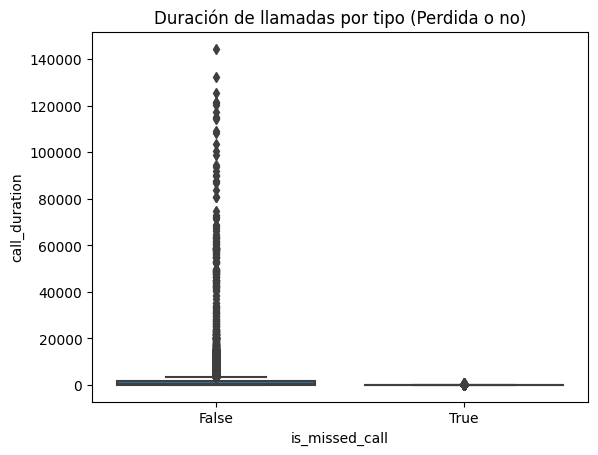

In [15]:
sns.boxplot(x='is_missed_call', y='call_duration', data=df_telecom)
plt.title("Duración de llamadas por tipo (Perdida o no)")
plt.show()

<div class="alert alert-block alert-success">
<b>Celda [15]</b> <a class="tocSkip"></a><br>
La visualización de la duración de las llamadas por tipo utilizando un boxplot es una excelente manera de identificar patrones y posibles outliers en los datos. Esto te permite explorar la distribución de los datos y detectar cualquier anomalía que pueda requerir una atención especial.
</div>


In [16]:
print(df_telecom.dtypes)


user_id                                                int64
date                   datetime64[ns, pytz.FixedOffset(180)]
direction                                             object
internal                                                bool
operator_id                                           object
is_missed_call                                          bool
calls_count                                            int64
call_duration                                          int64
total_call_duration                                    int64
dtype: object


In [17]:
df_telecom['call_duration'] = pd.to_numeric(df_telecom['call_duration'], errors='coerce')


<div class="alert alert-block alert-warning">
<b>Celda [17]</b> <a class="tocSkip"></a><br>
Al convertir 'call_duration' a un formato numérico, asegúrate de manejar adecuadamente los valores que no se pueden convertir. Considera reemplazarlos con la mediana o media de la columna si es apropiado para tu análisis, ya que esto puede ayudar a mantener la integridad de los datos y evitar sesgos.
</div>


In [18]:
df_telecom['is_missed_call'] = df_telecom['is_missed_call'].astype('category')


In [19]:
print(df_telecom[['is_missed_call', 'call_duration']].head())
print(df_telecom[['is_missed_call', 'call_duration']].isnull().sum())

  is_missed_call  call_duration
0           True              0
1           True              0
2           True              0
3          False             10
4           True              0
is_missed_call    0
call_duration     0
dtype: int64


In [20]:
# Ver proporción de llamadas con duración cero
(df_telecom['call_duration'] == 0).mean()

0.43157953322696746

<div class="alert alert-block alert-success">
<b>Celda [20]</b> <a class="tocSkip"></a><br>
Has calculado la proporción de llamadas con duración cero, lo cual es un paso importante para entender la calidad de los datos y su posible impacto en el análisis. Esto te ayudará a evaluar si estas llamadas deben ser tratadas de manera especial en tu análisis.
</div>


In [21]:
df_telecom[df_telecom['operator_id'].isnull()][['direction', 'internal', 'is_missed_call']].value_counts()

Series([], dtype: int64)

# DataFrame 2

In [22]:
df_telecomclients = pd.read_csv('/datasets/telecom_clients_us.csv')

In [23]:
df_telecomclients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [24]:
df_telecomclients['date_start'] = pd.to_datetime(df_telecomclients['date_start'])


In [25]:
print(df_telecomclients.isnull().sum())    

user_id        0
tariff_plan    0
date_start     0
dtype: int64


In [26]:
print(df_telecomclients.duplicated().sum())

0


In [27]:
# Ver los primeros valores
print(df_telecom[['is_missed_call', 'call_duration']].head(10))

# Tipos de datos
print(df_telecom.dtypes)

# Conteo de valores nulos
print(df_telecom[['is_missed_call', 'call_duration']].isnull().sum())

# Conteo de valores únicos de 'is_missed_call'
print(df_telecom['is_missed_call'].value_counts(dropna=False))

  is_missed_call  call_duration
0           True              0
1           True              0
2           True              0
3          False             10
4           True              0
5          False              3
6           True              0
7           True              0
8           True              0
9           True              0
user_id                                                int64
date                   datetime64[ns, pytz.FixedOffset(180)]
direction                                             object
internal                                                bool
operator_id                                           object
is_missed_call                                      category
calls_count                                            int64
call_duration                                          int64
total_call_duration                                    int64
dtype: object
is_missed_call    0
call_duration     0
dtype: int64
False    30334
True     23568
Na

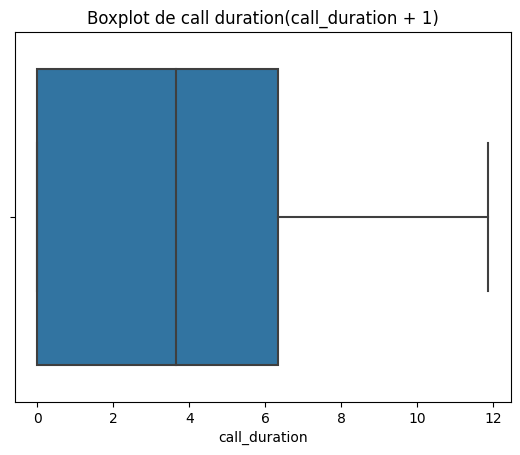

In [28]:
sns.boxplot(x=np.log1p(df_telecom['call_duration']))
plt.title('Boxplot de call duration(call_duration + 1)')
plt.show()

In [29]:
df_telecom.dtypes[df_telecom.dtypes == "category"]


is_missed_call    category
dtype: object

In [30]:
df_telecom['is_missed_call'] = df_telecom['is_missed_call'].astype(int)


## proporcion de llamadas perdidas por operados

In [31]:
operator_stats = df_telecom[df_telecom['operator_id'].notna()].groupby('operator_id').agg(
    total_calls=('is_missed_call', 'count'),
    missed_calls=('is_missed_call', 'sum'),
    avg_duration=('call_duration', 'mean')
)

operator_stats['missed_ratio'] = operator_stats['missed_calls'] / operator_stats['total_calls']
operator_stats = operator_stats.sort_values('missed_ratio', ascending=False)
operator_stats.head(10)

,total_calls,missed_calls,avg_duration,missed_ratio
operator_id,,,,
932246.0,1,1,0.0,1.0
962904.0,1,1,0.0,1.0
941826.0,1,1,0.0,1.0
945074.0,1,1,0.0,1.0
891976.0,1,1,0.0,1.0
914272.0,1,1,0.0,1.0
928284.0,1,1,0.0,1.0
885682.0,3,3,0.0,1.0
954284.0,1,1,0.0,1.0


## visualizacion de operadores ineficaces

In [32]:
min_calls = 30 

filtered_stats = operator_stats[operator_stats['total_calls'] >= min_calls]

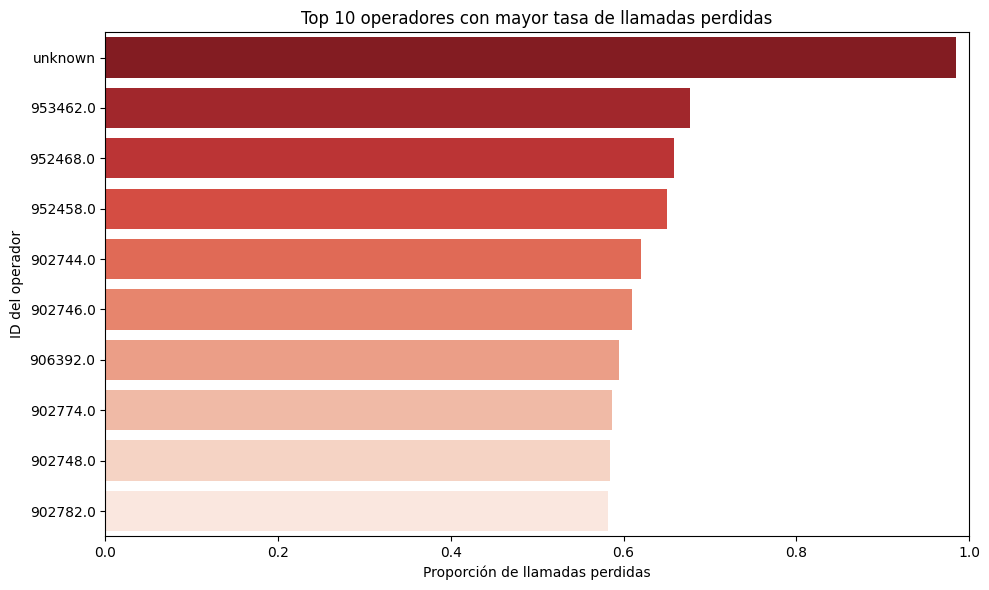

In [33]:
top_inefficient = filtered_stats.sort_values('missed_ratio', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_inefficient['missed_ratio'],
    y=top_inefficient.index.astype(str),  # para mostrar el ID del operador
    palette='Reds_r'
)

plt.xlabel('Proporción de llamadas perdidas')
plt.ylabel('ID del operador')
plt.title('Top 10 operadores con mayor tasa de llamadas perdidas')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Celda [33]</b> <a class="tocSkip"></a><br>
La visualización de los operadores con mayor proporción de llamadas perdidas es una excelente manera de identificar áreas problemáticas. Utilizar gráficos para comunicar tus hallazgos de manera efectiva es clave para que otros puedan entender y actuar sobre los resultados de tu análisis.
</div>


<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Emanuel! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
• Cargaste y exploraste los datos de manera efectiva, asegurándote de comprender su estructura.<br>
• Identificaste y trataste los valores nulos adecuadamente, lo cual es crucial para el análisis.<br>
• Convertiste las columnas a los tipos de datos apropiados, como las fechas, facilitando el análisis temporal.<br>
• Realizaste un análisis detallado de duplicados y valores nulos, asegurando la integridad de los datos.<br>
• Usaste visualizaciones para explorar patrones en los datos, lo que enriqueció tu análisis.<br>
• Calculaste métricas clave, como la proporción de llamadas con duración cero, para evaluar la calidad de los datos.<br>
• Aplicaste transformaciones a los datos cuando fue necesario, mejorando la interpretación de los resultados.<br>
• Documentaste tus pasos y decisiones de manera clara, facilitando la comprensión de tu proceso.<br>
• Identificaste operadores con problemas mediante análisis visual, destacando áreas para mejora.<br>
• Mantuviste un flujo de trabajo organizado y lógico, asegurando la coherencia del análisis.<br>
¡Felicidades!
</div>
